# Предсказание времени исправления багов в gcc

Задача состоит в предсказании времени, необходимого на исправление багов, на основе описания бага.

Набор данных содержит многолетние логи.

### Импорт нужных модулей

In [26]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import re
%matplotlib inline

### Читаем данные

In [3]:
data_url = 'https://raw.githubusercontent.com/Sandro295/Masters-ML/main/gcc_bug_report_data.csv'
data_raw = pd.read_csv(data_url)

data_raw.shape

(10000, 19)

Датасет состоит из _10 000_ записей и _19_ признаков

Посмотрим на загруженные данные

In [4]:
data_raw.head(5)

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
0,GCC-49282,2011-06-04,middle-end,GCC,malloc corruption in large lto1-wpa run during...,A large lto1-wpa run with 20110603 results now...,unassigned,andi-gcc,fixed,1,resolved,4,2011-10-07,0,9,2011-10-07,125,normal,2
1,GCC-36574,2008-06-19,middle-end,GCC,[4.4 Regression] build broken with cgraph changes,With r136888 cris-elf built (and had just 4 re...,unassigned,hp,fixed,1,resolved,4,2008-07-18,0,5,2008-07-18,29,normal,2
2,GCC-77269,2016-08-16,middle-end,GCC,__builtin_isinf_sign does not work for __float128,The __builtin_isinf_sign folding does\n\n ...,jsm28,jsm28,fixed,1,resolved,4,2016-08-22,0,5,2016-08-22,6,normal,2
3,GCC-78479,2016-11-22,fortran,GCC,ICE in gfc_apply_init at fortran/expr.c:4135,With valid code down to at least 4.8 :\n\n\n$ ...,kargl,gerhard.steinmetz.fortran,fixed,1,resolved,4,2016-11-22,0,6,2016-11-22,0,normal,2
4,GCC-632,2000-10-12,c++,GCC,Internal compiler error in `layout_decl' at st...,g++ -I/home/leila/Sources/Include -O2 -Wall -...,unassigned,lkh,fixed,1,resolved,4,2003-07-25,0,5,2001-02-04,115,normal,2


Видно, что данные состоят из числовых, категориальных и текстовых признаков.

## Список признаков и их описания

In [5]:
data_raw.dtypes

bug_id                  object
creation_date           object
component_name          object
product_name            object
short_description       object
long_description        object
assignee_name           object
reporter_name           object
resolution_category     object
resolution_code          int64
status_category         object
status_code              int64
update_date             object
quantity_of_votes        int64
quantity_of_comments     int64
resolution_date         object
bug_fix_time             int64
severity_category       object
severity_code            int64
dtype: object

Заранее поменяем тип у категориальных признаков (с _object_ на _category_)

In [6]:
for column in data_raw.select_dtypes(['object']):
    data_raw[column] = data_raw[column].astype('category')

In [7]:
data_raw.dtypes

bug_id                  category
creation_date           category
component_name          category
product_name            category
short_description       category
long_description        category
assignee_name           category
reporter_name           category
resolution_category     category
resolution_code            int64
status_category         category
status_code                int64
update_date             category
quantity_of_votes          int64
quantity_of_comments       int64
resolution_date         category
bug_fix_time               int64
severity_category       category
severity_code              int64
dtype: object

### Входные признаки

####  Числовые признаки

* __bug_id__ - уникальный идентификатор бага
* __creation_date__ - дата создания тикета
* __resolution_category__ - статус задачи
* __status_code__ - код задачи
* __update_date__ - дата последнего обновления тикета
* __quantity_of_votes__ - количество голосов в тикете
* __quantity_of_comments__ - количество комментариев
* __resolution_date__ - дата закрытия тикета
* __bug_fix_time__ - время исправления бага в днях
* __severity_category__ - уровень критичности бага
* __severity_code__ - код уровня критичности бага

####  Категориальные признаки

* __component_name__ - компонент продукта с ошибкой
* __product_name__ - продукт с ошибкой
* __assignee_name__ - никнейм взявшего тикет
* __reporter_name__ - никнейм ответственного за проверку

####  Текстовые признаки
* __short_description__ - краткое описание появившейся проблемы
* __long_description__ - подробное описание проблемы


### Выходной признак

* __bug_fix_time__ - время разрешения тикета

## Чистка данных

In [8]:
data_raw.describe()

,resolution_code,status_code,quantity_of_votes,quantity_of_comments,bug_fix_time,severity_code
count,10000.0,10000.000000,10000.0,10000.000000,10000.0000,10000.00000
mean,1.0,4.019400,0.0,8.145000,225.8268,2.22120
std,0.0,0.196029,0.0,6.553859,516.6366,0.79758
min,1.0,4.000000,0.0,1.000000,-527.0000,1.00000
25%,1.0,4.000000,0.0,4.000000,3.0000,2.00000
50%,1.0,4.000000,0.0,6.000000,27.0000,2.00000
75%,1.0,4.000000,0.0,10.000000,188.0000,2.00000
max,1.0,6.000000,0.0,124.000000,5351.0000,6.00000


Первым делом очистим данные. __bug_id__ уникален для каждого, поэтому его можно заменить порядковым номером строки, 
__xx_category__ и __xx_code__ несут одинаковую информацию.
__product_name__ в этом датасете один. __resolution_category__ везде 1.
__update_date__ и __resolution_date__ как правило одинаковы.
__quantity_of_votes__ везде 0.


In [9]:
data_raw.isna().sum()

bug_id                   0
creation_date            0
component_name           0
product_name             0
short_description        6
long_description        14
assignee_name            0
reporter_name            0
resolution_category      0
resolution_code          0
status_category          0
status_code              0
update_date              0
quantity_of_votes        0
quantity_of_comments     0
resolution_date          0
bug_fix_time             0
severity_category        0
severity_code            0
dtype: int64

Также избавимся от строк с пропущенными данными.

In [10]:
data = data_raw.drop(['bug_id','severity_category', 'product_name', 'update_date', 'resolution_category', 'resolution_code', 'status_category', 'quantity_of_votes'], axis=1).dropna()

In [11]:
data_raw.describe(include=['category'])

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,status_category,update_date,resolution_date,severity_category
count,10000,10000,10000,10000,9994,9986,10000,10000,10000,10000,10000,10000,10000
unique,10000,4846,55,2,9928,9958,270,3287,1,2,3642,4490,6
top,CLASSPATH-16040,2000-12-20,c++,GCC,Internal compiler error,,unassigned,hjl.tools,fixed,resolved,2003-07-25,2005-07-23,normal
freq,1,77,2217,9731,9,19,5149,292,10000,9903,1553,58,8895


In [12]:
data.describe(include=['category'])

,creation_date,component_name,short_description,long_description,assignee_name,reporter_name,resolution_date
count,9980,9980,9980,9980,9980,9980,9980
unique,4840,55,9914,9953,270,3275,4487
top,2000-12-20,c++,Internal compiler error,,unassigned,hjl.tools,2005-07-23
freq,77,2213,9,19,5136,292,58


In [13]:
data.head(5)

,creation_date,component_name,short_description,long_description,assignee_name,reporter_name,status_code,quantity_of_comments,resolution_date,bug_fix_time,severity_code
0,2011-06-04,middle-end,malloc corruption in large lto1-wpa run during...,A large lto1-wpa run with 20110603 results now...,unassigned,andi-gcc,4,9,2011-10-07,125,2
1,2008-06-19,middle-end,[4.4 Regression] build broken with cgraph changes,With r136888 cris-elf built (and had just 4 re...,unassigned,hp,4,5,2008-07-18,29,2
2,2016-08-16,middle-end,__builtin_isinf_sign does not work for __float128,The __builtin_isinf_sign folding does\n\n ...,jsm28,jsm28,4,5,2016-08-22,6,2
3,2016-11-22,fortran,ICE in gfc_apply_init at fortran/expr.c:4135,With valid code down to at least 4.8 :\n\n\n$ ...,kargl,gerhard.steinmetz.fortran,4,6,2016-11-22,0,2
4,2000-10-12,c++,Internal compiler error in `layout_decl' at st...,g++ -I/home/leila/Sources/Include -O2 -Wall -...,unassigned,lkh,4,5,2001-02-04,115,2


## Визуализация и предварительный анализ данных

### Описательная статистика матрицы данных

#### Информация о числовых признаках

In [14]:
data.describe()

,status_code,quantity_of_comments,bug_fix_time,severity_code
count,9980.000000,9980.000000,9980.000000,9980.000000
mean,4.019038,8.147094,225.961222,2.221443
std,0.194210,6.557003,516.901518,0.798122
min,4.000000,1.000000,-527.000000,1.000000
25%,4.000000,4.000000,3.000000,2.000000
50%,4.000000,6.000000,27.000000,2.000000
75%,4.000000,10.000000,188.000000,2.000000
max,6.000000,124.000000,5351.000000,6.000000


По таблице можно увидеть, что какие-то баги решались за отрицательное время, что можно трактовать как позднее создание тикета или выброс в данных, от которого надо избавиться.

In [15]:
data.drop(data[data.bug_fix_time < 0].index, inplace=True)
data.describe()

,status_code,quantity_of_comments,bug_fix_time,severity_code
count,9928.000000,9928.000000,9928.000000,9928.000000
mean,4.019138,8.154613,228.494158,2.221998
std,0.194713,6.569078,516.972198,0.799083
min,4.000000,1.000000,0.000000,1.000000
25%,4.000000,4.000000,3.000000,2.000000
50%,4.000000,6.000000,28.000000,2.000000
75%,4.000000,10.000000,190.000000,2.000000
max,6.000000,124.000000,5351.000000,6.000000


### Визуализация данных

В процессе визуализации могут проявиться некоторые особенности данных, с которыми необходимо будет разобраться

Посмотрим на сбалансированность/несбалансированность классов

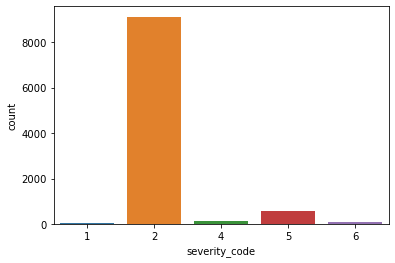

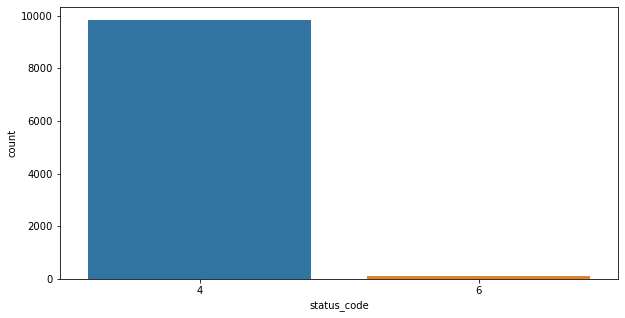

In [16]:
sns.countplot(x='severity_code', data=data)
plt.figure(figsize=(10, 5))
sns.countplot(x='status_code', data=data)
pass

Видно, что классы ___несбалансированны___. Впоследствии имеет смысл попытаться избавиться от несбалансированности.

У большинства багов одинаковая важность.

Построим графики зависимостей каждого количественного признака с каждым

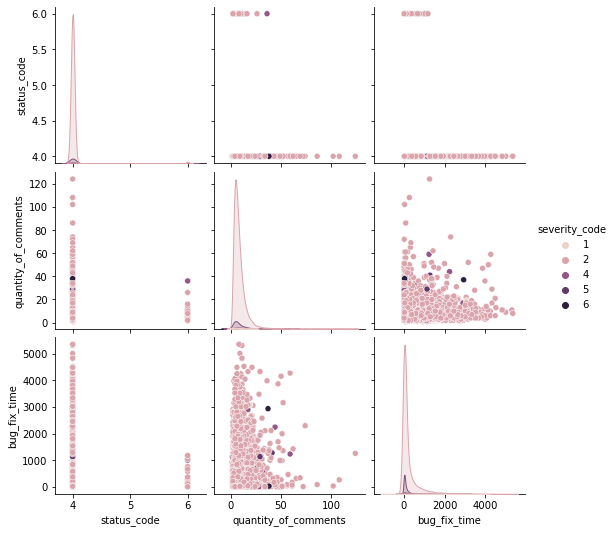

In [17]:
sns.pairplot(data, hue='severity_code')

Посмотрим на время решения проблемы относительно времени создания тикета. <br>_iloc[::dec]_ - добавим для децимации данных, чтобы не строить график от 10000 вхождений, потому что общие тренды можно увидеть и с меньшим количеством данных.

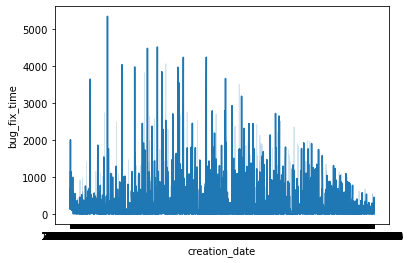

In [18]:
dec = 3
fixing_time_plot = sns.lineplot(x = data['creation_date'].iloc[::dec], y = data['bug_fix_time'].iloc[::dec]);

Видно, что GCC уже в зрелом состоянии и новые баги исправляются всё быстрее и быстрее.

Построим матрицу корреляции для количественных признаков и визуализируем её

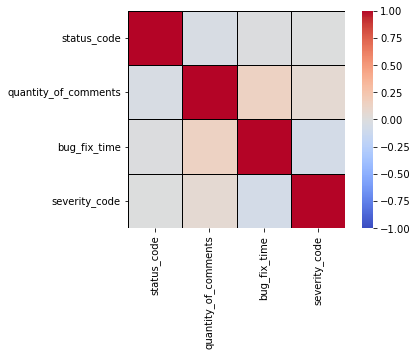

In [19]:
corr_mat = data.corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=1, linecolor="black")
pass

Напрашивается очевидный вывод: чем выше уровень критичности, тем дольше ведется дискуссия и дольше вносятся исправления.

## Обработка категориальных признаков

In [20]:
data.head()

,creation_date,component_name,short_description,long_description,assignee_name,reporter_name,status_code,quantity_of_comments,resolution_date,bug_fix_time,severity_code
0,2011-06-04,middle-end,malloc corruption in large lto1-wpa run during...,A large lto1-wpa run with 20110603 results now...,unassigned,andi-gcc,4,9,2011-10-07,125,2
1,2008-06-19,middle-end,[4.4 Regression] build broken with cgraph changes,With r136888 cris-elf built (and had just 4 re...,unassigned,hp,4,5,2008-07-18,29,2
2,2016-08-16,middle-end,__builtin_isinf_sign does not work for __float128,The __builtin_isinf_sign folding does\n\n ...,jsm28,jsm28,4,5,2016-08-22,6,2
3,2016-11-22,fortran,ICE in gfc_apply_init at fortran/expr.c:4135,With valid code down to at least 4.8 :\n\n\n$ ...,kargl,gerhard.steinmetz.fortran,4,6,2016-11-22,0,2
4,2000-10-12,c++,Internal compiler error in `layout_decl' at st...,g++ -I/home/leila/Sources/Include -O2 -Wall -...,unassigned,lkh,4,5,2001-02-04,115,2


Обработаем признаки _component_name_, _assignee_name_ и _reporter_name_. Поскольку они принимают уникальные текстовые значения, а смысл несет не столько предложение, сколько непосредственно само слово, удобным будет заменить их числовыми значениями.<br> Метод бинаризации (one-hot encoding) __не__ подойдет, потому что уникальных значений много (несколько сотен)

In [21]:
NamesDtype = pd.CategoricalDtype()
data['reporter_name'] = data['reporter_name']

In [22]:
# cat_columns = data.select_dtypes(['category'])
# cleanerdata = data
# cat_columns.drop(['creation_date', 'short_description', 'long_description', 'resolution_date'], axis=1, inplace=True)
# for column in cat_columns:
#     if cleanerdata[column].nunique() < 400:
#         cleanerdata[column] = cleanerdata[column].cat.remove_unused_categories()  # убираю неиспользуемые категории
#         df_dummies = pd.get_dummies(cleanerdata[column], prefix=column)  # one-hot encoding
#         cleanerdata.drop(column, axis=1, inplace=True)                   # удаляем из исходной таблицы "старые" признаки
#         cleanerdata = pd.concat([cleanerdata, df_dummies], axis=1)       # добавляем бинаризованные ("новые") признаки

In [23]:
# pd.set_option('display.max_columns', None)
# cleanerdata.describe().T

In [24]:
# cleanerdata.head()

# 

# __!!!!!!!!Skipping this till i try to learn the network!!!!!!!!__

## Обработка текстовых признаков

Признак _long_description_ содержит подробное описание проблемы, обычно с примерами _C_ кода, иногда даже с полученным _ASM_ кодом. Признак никак не нормирован и не подходит для анализа без предварительной обработки. <br>
Поскольку мне неизвестны продвинутые методы обработки осмысленных текстов, я воспользуюсь грубым, но простым и понятным методом _Bag of Words_ (BOW).

Признак _short_description_ содержит не более одного предложения, составленного из некоторых ключевых слов. Для него BOW подходит как нельзя лучше. 

Для использования метода BOW необходимо привести данные к единому виду. Для этого переведем все символы в строчные, а также применим stemming - грубое сокращение слов до их неизменяемой при склонении части. <br> 
А также удалим пунктуацию и стоп-слова. Здесь возникает небольшая проблема - в некоторых описаниях знаки пунктуации используются в программном смысле, т.е., например, scope resolvement operator «::» или member access operator «.». <br>
Оценка и так будет грубой, а с таким действием будет еще немного грубее. 

In [25]:
def lower(text):
    return text.lower()

In [29]:
from nltk.stem import PorterStemmer
  
def stemming(text):
    return ' '.join([PorterStemmer().stem(w) for w in text.split()])

In [46]:
from nltk.corpus import stopwords
from nltk import download
download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    return re.sub(r'[^\w\s]', '', text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

def remove_space(text):
    return re.sub(r"\s+"," ",text).strip()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
def filter_text(text):
    text = lower(text)
    text = stemming(text)
    text = punct_remove(text)
    text = remove_stopwords(text)
    text = remove_space(text)
    return text

In [49]:
data['short_description'] = data['short_description'].apply(lambda x:filter_text(x))

In [50]:
data['long_description'] = data['long_description'].apply(lambda x:filter_text(x))

## Word cloud

Посмотрим на самые частые слова в описаниях

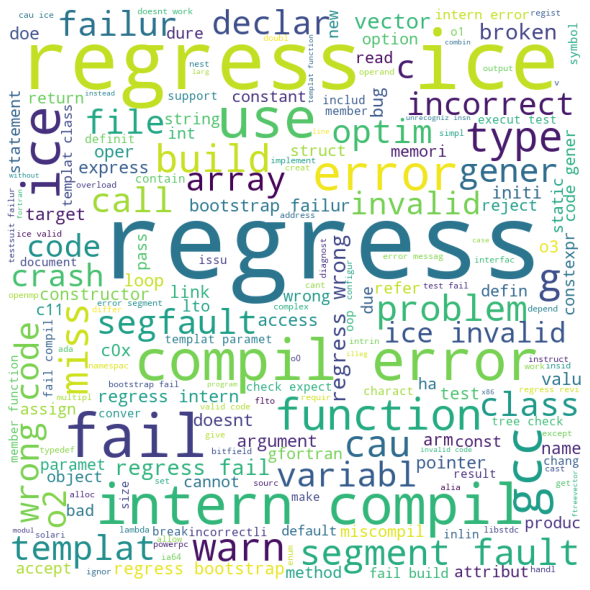

In [51]:
from wordcloud import WordCloud

text = " ".join(data['short_description'])

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text) 

plt.figure(figsize = (8, 8), facecolor = "white")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 

Можно подумать, что все беды из-за интернов, однако _intern_ - результат стемминга слова _internal_

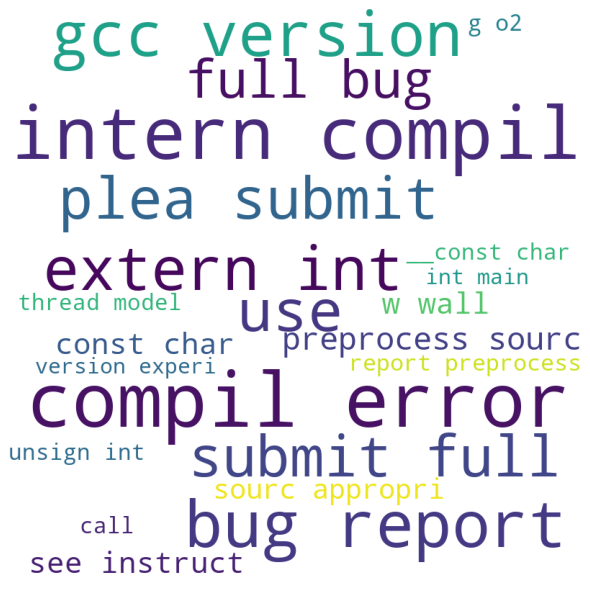

In [52]:
text = " ".join(data['long_description'])

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text) 

plt.figure(figsize = (8, 8), facecolor = "white")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

## Отбор признаков

В качестве целевого признака выберем признак _bug_fix_time_, а также уберем _creation_date_ и _resolution_date_

In [22]:
X = cleanerdata.drop(['bug_fix_time', 'creation_date', 'resolution_date', 'short_description', 'long_description', 'reporter_name'], axis=1)
y = cleanerdata['bug_fix_time']

Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 58)

X_train.shape, X_test.shape

((7446, 327), (2482, 327))

## Обучение классификаторов

In [24]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix

### Метод kNN

Обучаем _kNN_-классификатор по умолчанию (для ___k = 5___):

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors = 10)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

Вычисляем ошибку на тренировочной выборке

In [26]:
%%time
y_train_pred = knn_model.predict(X_train)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * (1 - accuracy_score(y_train, y_train_pred))))

Accuracy score on train data: 17.35%
         Error on train data: 82.65%
CPU times: total: 3.02 s
Wall time: 1.02 s


Вычисляем ошибку на тестовой выборке

In [27]:
%%time
y_test_pred = knn_model.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 8.26%
         Error on test  data: 91.74%
CPU times: total: 1.75 s
Wall time: 379 ms


Видно, что метод kNN совершенно не подходит к датасету с большим числом текстовых параметров.

Обучим несколько _kNN_-классификаторов для разных значений _k_ от 5 до 50 с шагом 5, при этом будем собирать значения полученных ошибок, чтобы потом проанализировать результаты.

In [28]:
%%time

acc_train = []
err_train = []
acc_test = []
err_test = []

k_values = range(5, 51, 5)

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    print('k = {}:'.format(k))
    
    y_train_pred = knn_model.predict(X_train)
    print('    Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
    print('             Error on train data: {:.2f}%'.format(100 * np.mean(y_train != y_train_pred)))
    acc_train.append(accuracy_score(y_train, y_train_pred))
    err_train.append(np.mean(y_train != y_train_pred))
    
    y_test_pred = knn_model.predict(X_test)
    print('    Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
    print('             Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))
    acc_test.append(accuracy_score(y_test, y_test_pred))
    err_test.append(np.mean(y_test != y_test_pred))

k = 5:
    Accuracy score on train data: 19.69%
             Error on train data: 80.31%
    Accuracy score on test  data: 7.33%
             Error on test  data: 92.67%
k = 10:
    Accuracy score on train data: 17.35%
             Error on train data: 82.65%
    Accuracy score on test  data: 8.26%
             Error on test  data: 91.74%
k = 15:
    Accuracy score on train data: 15.81%
             Error on train data: 84.19%
    Accuracy score on test  data: 8.42%
             Error on test  data: 91.58%
k = 20:
    Accuracy score on train data: 14.89%
             Error on train data: 85.11%
    Accuracy score on test  data: 8.18%
             Error on test  data: 91.82%
k = 25:
    Accuracy score on train data: 14.60%
             Error on train data: 85.40%
    Accuracy score on test  data: 8.82%
             Error on test  data: 91.18%
k = 30:
    Accuracy score on train data: 14.32%
             Error on train data: 85.68%
    Accuracy score on test  data: 9.15%
             Err

Посмотрим на графики за значениями точности и ошибки на тренировочном и тестовом наборах при различных значениях k

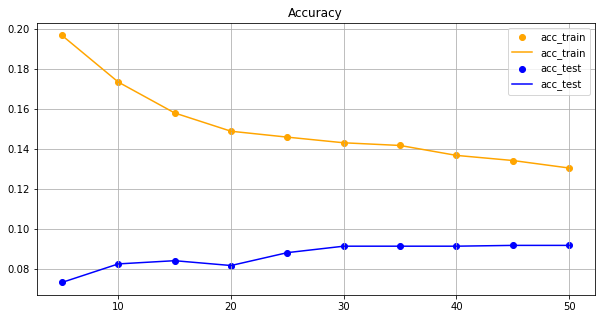

In [29]:
fig = plt.figure(figsize=(10, 5))

plt.title('Accuracy')
plt.scatter(list(k_values)[::-1], acc_train[::-1], color='orange', label='acc_train')
plt.plot(list(k_values)[::-1], acc_train[::-1], color='orange', label='acc_train')

plt.scatter(list(k_values)[::-1], acc_test[::-1], color='blue', label='acc_test')
plt.plot(list(k_values)[::-1], acc_test[::-1], color='blue', label='acc_test')

plt.grid()
plt.legend()

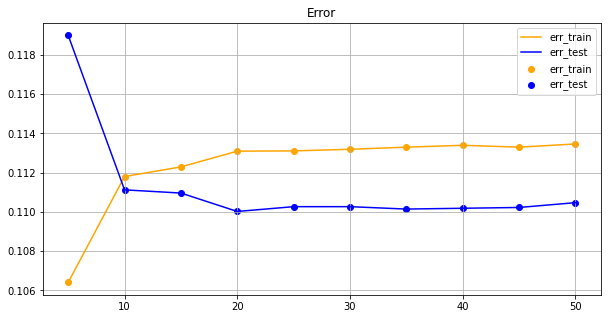

In [ ]:
fig = plt.figure(figsize=(10, 5))

plt.title('Error')
plt.scatter(list(k_values)[::-1], err_train[::-1], color='orange', label='err_train')
plt.plot(list(k_values)[::-1], err_train[::-1], color='orange', label='err_train')

plt.scatter(list(k_values)[::-1], err_test[::-1], color='blue', label='err_test')
plt.plot(list(k_values)[::-1], err_test[::-1], color='blue', label='err_test')

plt.grid()
plt.legend()

Наилучшая точность получена при ___k = 20___, однако разница не столь велика. Точность держится на уровне 88-89%. Имеет смысл сравнить с другими типами классификаторов.

### Алгоритм Random Forest

Обучим классификатор на основе алгоритма _Random Forest_

In [ ]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=500)
rf_model.fit(X_train, y_train)

CPU times: user 1min 40s, sys: 10.4 s, total: 1min 51s
Wall time: 1min 53s


RandomForestClassifier(n_estimators=500)

Вычисляем ошибку на тренировочной выборке

In [ ]:
%%time
y_train_pred = rf_model.predict(X_train)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train != y_train_pred)))

Accuracy score on train data: 100.00%
         Error on train data: 0.00%
CPU times: user 19.1 s, sys: 4.76 s, total: 23.8 s
Wall time: 23.8 s


Вычисляем ошибку на тестовой выборке

In [ ]:
%%time
y_test_pred = rf_model.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 88.99%
         Error on test  data: 11.01%
CPU times: user 6.47 s, sys: 23.1 ms, total: 6.49 s
Wall time: 7.01 s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


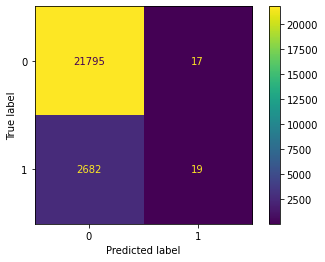

In [ ]:
plot_confusion_matrix(rf_model, X_test, y_test)

Глядя на матрицу рассогласования, видно, что из-за несбалансированности классов, качество работы нашей обученной модели оставляет желать лучшего.

Использование алгоритма _Random Forest_ не улучшило результаты.

In [ ]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

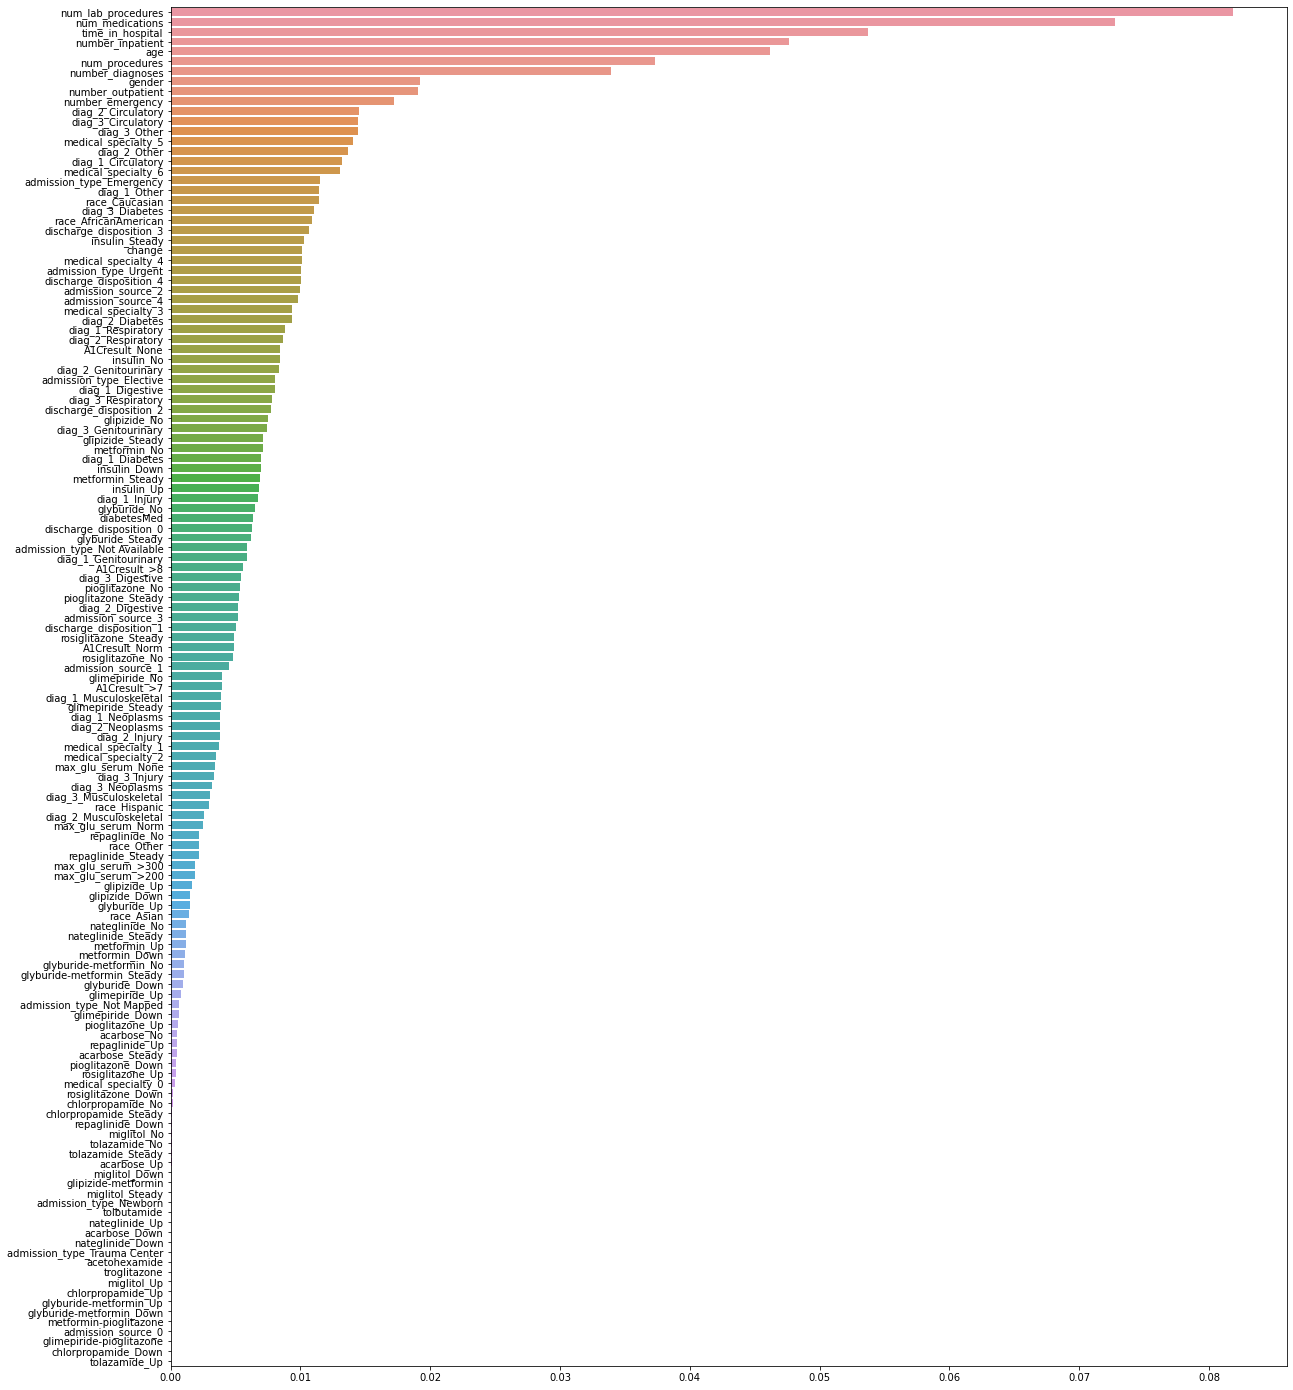

In [ ]:
fig = plt.figure(figsize=(20, 25))
sns.barplot(y=importances.index, x=importances, orient='h')
pass

### Алгоритм Logistic Regression

Обучим классификатор на основе алгоритма _Logistic Regression_

In [ ]:
%%time

from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver='newton-cg')
lr_model.fit(X_train, y_train)

CPU times: user 48.4 s, sys: 4.95 s, total: 53.4 s
Wall time: 27.6 s


LogisticRegression(solver='newton-cg')

Вычисляем ошибку на тренировочной выборке

In [ ]:
y_train_pred = lr_model.predict(X_train)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train != y_train_pred)))

Accuracy score on train data: 88.62%
         Error on train data: 11.38%


Вычисляем ошибку на тестовой выборке

In [ ]:
y_test_pred = lr_model.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 88.90%
         Error on test  data: 11.10%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


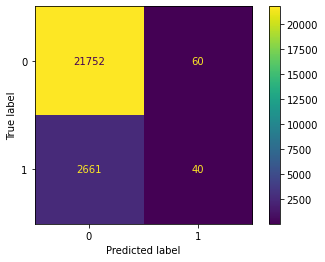

In [ ]:
plot_confusion_matrix(lr_model, X_test, y_test)

Глядя на матрицу рассогласования, видно, что из-за несбалансированности классов, качество работы нашей обученной модели оставляет желать лучшего.

Использование алгоритма _Logistic Regression_ также не улучшило результаты.

### Алгоритм SGDClassifier

Обучим классификатор на основе алгоритма _SGD_

In [ ]:
%%time

from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss='log', random_state=58)
sgd_model.fit(X_train, y_train)

CPU times: user 2.05 s, sys: 22.5 ms, total: 2.07 s
Wall time: 2.09 s


SGDClassifier(loss='log', random_state=58)

Вычисляем ошибку на тренировочной выборке

In [ ]:
y_train_pred = sgd_model.predict(X_train)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train != y_train_pred)))

Accuracy score on train data: 88.43%
         Error on train data: 11.57%


Вычисляем ошибку на тестовой выборке

In [ ]:
y_test_pred = sgd_model.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 88.49%
         Error on test  data: 11.51%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


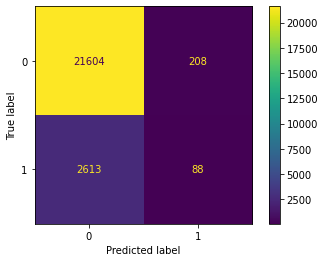

In [ ]:
plot_confusion_matrix(sgd_model, X_test, y_test)

Глядя на матрицу рассогласования, видно, что из-за несбалансированности классов, качество работы нашей обученной модели оставляет желать лучшего.

Использование алгоритма _SGD_ также не улучшило результаты.

## Выводы

* Лучшая точность, которой удалось добиться на тестовой выборке - 89% достигнута методом _kNN_ при _k = 20_.
* Ни один из других предложенных алгоритмов не смог добиться лучшей точности. Но при этом все алгоритмы показывают приблизительно похожую точность предсказывания на тестовой выборке.
* По матрицам рассогласования для обученных моделей можно сказать, что у всех из них довольно велико значение ошибки второго рода, что опасно. Возможно, получится улучшить результаты после борьбы с несбалансированностью классов.
* Метод _kNN_ по времени работает сильно дольше остальных методов.